In [2]:
# https://www.tensorflow.org/tutorials/keras/text_classification

import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
print(tf.__version__)

2.6.0


In [3]:
# Sentiment analysis. (Download and extract the dataset)
"""This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, 
based on the text of the review"""

https_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
http_url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
try:
    dataset = tf.keras.utils.get_file("aclImdb_v1", https_url,
                                        untar=True, cache_dir='.',
                                        cache_subdir='')
except:
    dataset = tf.keras.utils.get_file("aclImdb_v1", http_url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [4]:
# Directory structure.
os.listdir(dataset_dir)

['README', 'test', 'imdb.vocab', 'train', 'imdbEr.txt']

In [4]:
# Train dir.
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'labeledBow.feat',
 'unsupBow.feat']

In [5]:
# Directories contain many text files, each of which is a single movie review.
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


# Load the dataset.

In [6]:
# Remove dataset additional folders.
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [7]:
# Create a validation set. (80:20)
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2021-08-12 18:06:32.900006: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# If you're new to tf.data, you can also iterate over the dataset and print out a few examples as follows.
# The labels are 0 or 1. 
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])
        print("\n")

2021-08-12 18:06:33.157626: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [9]:
# To see which of these correspond to positive and negative movie reviews, you can check the class_names property on the dataset.
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [10]:
# Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.
# Validation.
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [11]:
# Test.
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


# Prepare the dataset for training.

In [12]:
# Next, you will standardize, tokenize, and vectorize the data using the helpful preprocessing.TextVectorization layer.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [13]:
# Next, you will create a TextVectorization layer.
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [14]:
# Next, you will call adapt to fit the state of the preprocessing layer to the dataset.
# This will cause the model to build an index of strings to integers.
# Make a text-only dataset (without labels), then call adapt.
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [15]:
# Let's create a function to see the result of using this layer to preprocess some data.
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [16]:
# Retrieve a batch (of 32 reviews and labels) from the dataset.
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [17]:
# As you can see above, each token has been replaced by an integer. You can lookup the token (string) that
# each integer corresponds to by calling .get_vocabulary() on the layer.
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [18]:
# You are nearly ready to train your model. As a final preprocessing step, you will apply
# the TextVectorization layer you created earlier to the train, validation, and test dataset.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Configure the dataset for performance.
These are two important methods you should use when loading data to make sure that I/O does not become blocking.
- .cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.
- .prefetch() overlaps data preprocessing and model execution while training.

In [19]:
# Example.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model.

In [20]:
# Create a neural network.
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:
- The first layer is an Embedding layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). To learn more about embeddings, see the word embedding tutorial.
- Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
- This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
- The last layer is densely connected with a single output node.

# Loss function and optimizer.

In [21]:
# Configure the model to use an optimizer and a loss function.
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [22]:
# Train model.
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 6s 8ms/step - loss: 0.6649 - binary_accuracy: 0.6973 - val_loss: 0.6177 - val_binary_accuracy: 0.7708
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5519 - binary_accuracy: 0.7976 - val_loss: 0.5015 - val_binary_accuracy: 0.8222
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4475 - binary_accuracy: 0.8443 - val_loss: 0.4224 - val_binary_accuracy: 0.8468
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3799 - binary_accuracy: 0.8646 - val_loss: 0.3751 - val_binary_accuracy: 0.8606
Epoch 5/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3376 - binary_accuracy: 0.8769 - val_loss: 0.3461 - val_binary_accuracy: 0.8674
Epoch 6/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3059 - binary_accuracy: 0.8884 - val_loss: 0.3269 - val_binary_accuracy: 0.8716
Epoch 7/10
625/625 [==============================] - 4s 7ms/st

In [23]:
# Evaluate the model.
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 5s 6ms/step - loss: 0.3105 - binary_accuracy: 0.8736
Loss:  0.31049656867980957
Accuracy:  0.8735600113868713


In [24]:
# Create a plot of accuracy and loss over time.
# model.fit() returns a History object that contains a dictionary with everything that happened during training.
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

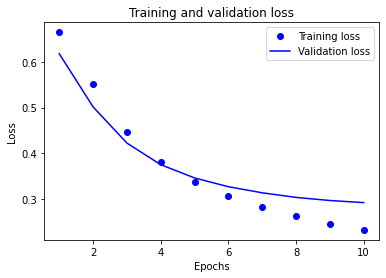

In [25]:
# There are four entries: one for each monitored metric during training and validation. 
# You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy.
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

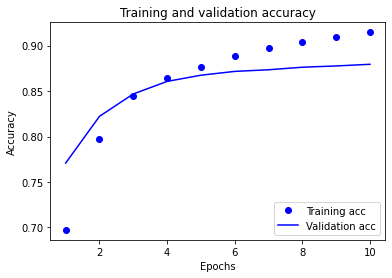

In [26]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Export the model.

In the code above, you applied the TextVectorization layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

In [27]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 5s 6ms/step - loss: 0.3105 - accuracy: 0.8736
0.8735600113868713


In [28]:
# Inference on new data.
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

model_result = export_model.predict(examples)
model_result

array([[0.60378957],
       [0.42513633],
       [0.34532246]], dtype=float32)

In [29]:
# Save model as .pb
export_model.save("model")

2021-08-12 18:07:53.263964: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/assets


In [30]:
# Get TFLite from a pb model. (https://github.com/tensorflow/models/issues/8872)
converter = tf.lite.TFLiteConverter.from_saved_model("model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
open("imdb.tflite","wb").write(tflite_model)

2021-08-12 18:07:57.462764: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2021-08-12 18:07:57.462794: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2021-08-12 18:07:57.462802: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored change_concat_input_ranges.
2021-08-12 18:07:57.468243: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: model
2021-08-12 18:07:57.481759: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2021-08-12 18:07:57.481800: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: model
2021-08-12 18:07:57.523868: I tensorflow/cc/saved_model/loader.cc:211] Restoring SavedModel bundle.
2021-08-12 18:07:57.606584: I tensorflow/cc/saved_model/loader.cc:195] Running initialization op on SavedModel bundle at path: model
2021-08-12 18:07:57.759171: I tensor

357472

In [31]:
# Preload model.
from tensorflow import (
    convert_to_tensor,
    lite,
)
import numpy as np
model_path="imdb.tflite"
interpreter = lite.Interpreter(model_path=str(model_path), num_threads=4)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite delegate for select TF ops.
INFO: TfLiteFlexDelegate delegate: 6 nodes delegated out of 33 nodes with 3 partitions.

INFO: TfLiteFlexDelegate delegate: 0 nodes delegated out of 2 nodes with 0 partitions.



In [32]:
# TFLite prediction.
result = {}
for ex in examples:
    text = np.expand_dims(np.array(ex), axis=0)
    interpreter.set_tensor(input_details[0]['index'], text)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])
    result.update({ex:prediction[0][0]})
result

{'The movie was great!': 0.6273476,
 'The movie was okay.': 0.44983825,
 'The movie was terrible...': 0.36804983}

In [33]:
print(result)
print(model_result)

{'The movie was great!': 0.6273476, 'The movie was okay.': 0.44983825, 'The movie was terrible...': 0.36804983}
[[0.60378957]
 [0.42513633]
 [0.34532246]]


In [34]:
new_example = "this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert # is an amazing actor and now the same being director # father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for # and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also # to the two little boy's that played the # of norman and paul they were just brilliant children are often left out of the # list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us all"

In [35]:
model_result = export_model.predict([new_example])
model_result

array([[0.9948372]], dtype=float32)

In [36]:
text = np.expand_dims(np.array(new_example), axis=0)
interpreter.set_tensor(input_details[0]['index'], text)
interpreter.invoke()
prediction = interpreter.get_tensor(output_details[0]['index'])
prediction

array([[0.9948807]], dtype=float32)